In [75]:
import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.signal as signal
import xarray as xr

from scipy.interpolate import interp1d
from scipy.signal import medfilt
from utils.data_reading.sound_data.station import StationsCatalog

In [81]:
#Choix des variables
station_name = "MAHY13" # Select the station
depth_choice = 1300 # Select a depth (m) for the hydrology data (e.g. the SOFAR canal)
frequency = 5 # Select a frequency (Hz) at which you want to know the median amplitude

# Chargement des données
sys.path.append("/home/imonge/PycharmProjects/PythonProject/toolbox/src")

catalog_path = "/media/imonge/CORSAIR"  # Path of the hard drive containing MAHY data
stations = StationsCatalog(catalog_path)
station = stations.by_name(station_name)[0]  # this will contain metadata about the selected station
manager = station.get_manager()  # this will enable to read data from the selected station

hydro_data = xr.open_dataset("/home/imonge/PycharmProjects/PythonProject/toolbox/src/data_copernicus/hydro_3/h3_total_time.nc") # Path of a directory containing the hydrology data (copernicus) for the station selected

In [82]:
# LTAS & vitesse du courant
date_start = datetime.datetime(2021,4,12,5,30,25)  # exemple : début le 10/10/21 à 5h30 et 25s
date_end = datetime.datetime(2021,4,22,5,30,25)
step = datetime.timedelta(seconds=3600)  # on lit les données par segments d'une heure
n_steps = (date_end-date_start)/step  # nombre de segments à calculer, attention c'est un nombre flottant
n_steps = int(n_steps)  # on transforme le nombre flottant en nombre entier
psds = []  # liste des psd de chaque segment, on va la remplir segment par segment

for i in range(n_steps):
    segment_start = date_start + i * step  # début du ième segment
    segment_end = date_start + (i+1) * step   # fin du ième segment
    data = manager.get_segment(segment_start, segment_end)
    psd_frequencies, psd = signal.welch(data, fs=240, nperseg=1024)  # fs est la fréquence d’échantillonnage, nperseg le nombre de points utilisés par transformée de Fourier. La résolution fréquentielle du résultats est 240/256 Hz
    psds.append(psd)

/tmp/ipykernel_25891/1899579608.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
/tmp/ipykernel_25891/1899579608.py:29: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


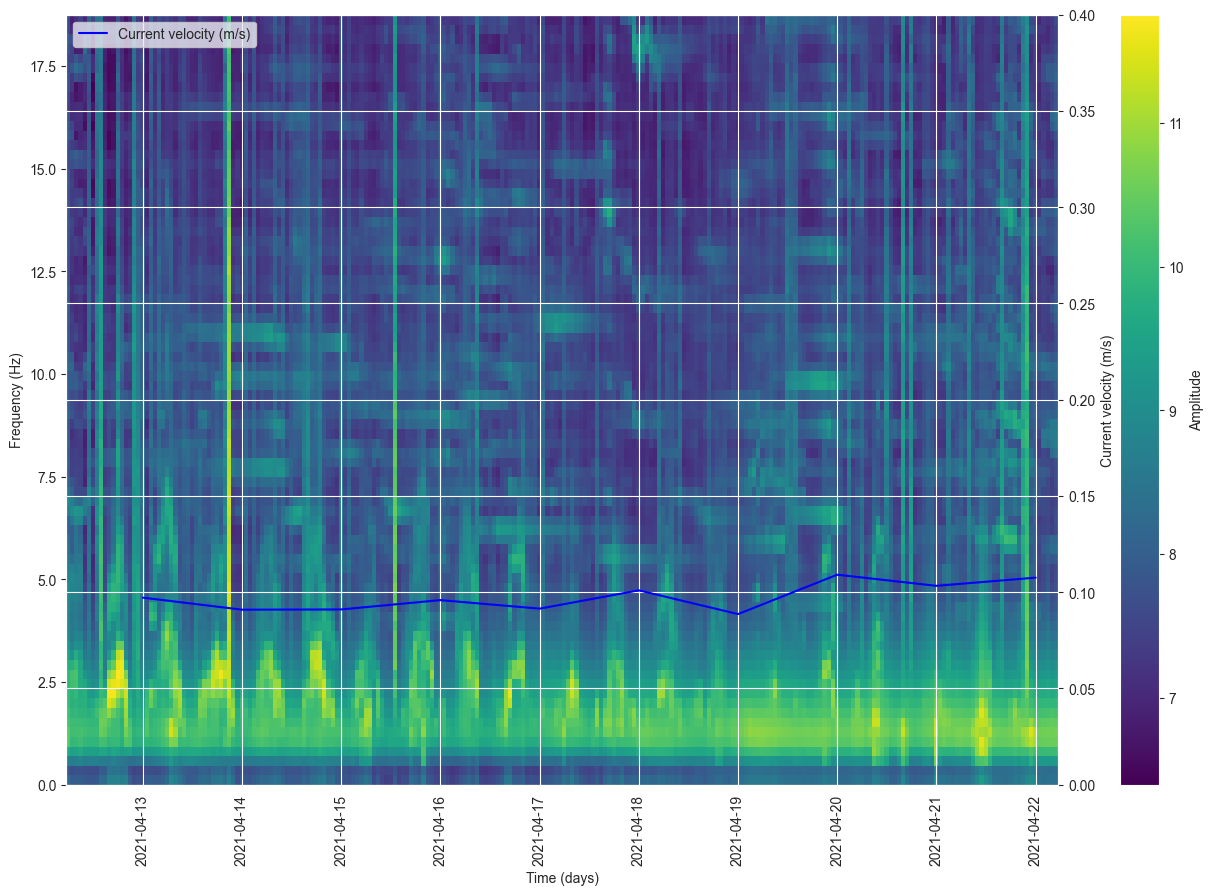

In [83]:
# Spectrogram with current velocity
fig, ax = plt.subplots(figsize = (16,10))
ax1 = ax.twinx() # Second axis for current speed
f_max = 80 # Maximum frequency on the spectrogram
sp = ax.imshow(np.log10(psds)[:,:f_max].T, aspect="auto", cmap="viridis", origin="lower", extent=(date_start, date_end, psd_frequencies[0], psd_frequencies[f_max]))

t = pd.to_datetime(hydro_data["time"])
mask = (t>date_start) & (t<date_end) # Filter to only select the campaign dates

# Color bar amplitudes
cbar = plt.colorbar(sp, ax=ax)
cbar.set_label("Amplitude")

depth_index = np.argmin(abs(hydro_data["depth"].data-depth_choice)) # Finds the index in the dataset corresponding to the depth chosen
uo = np.array(hydro_data["uo"][:,depth_index]).flatten()
vo = np.array(hydro_data["vo"][:,depth_index]).flatten()

velocity_magnitude = np.sqrt(uo**2+vo**2)[mask] # Current velocity
ax1.plot(t[mask], velocity_magnitude,label="Current velocity (m/s)", color="blue")
ax1.set_ylim(0,0.4) #limites ax1
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.grid(False, axis='y') # No grid for the frequency

ax.set_xlabel("Time (days)")
ax.set_ylabel("Frequency (Hz)")
ax1.set_ylabel("Current velocity (m/s)")
ax1.legend(loc="upper left")

fig.show()

/tmp/ipykernel_25891/838169230.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
/tmp/ipykernel_25891/838169230.py:31: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


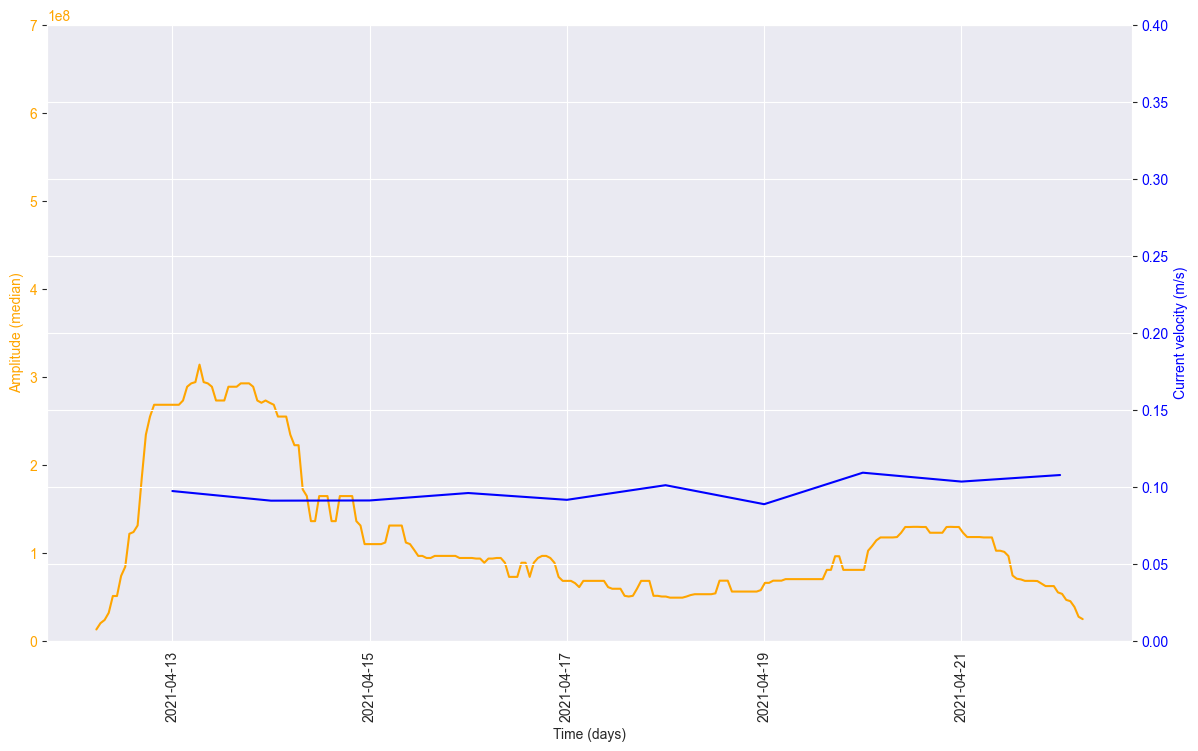

In [84]:
# Amplitude for a given freqeuncy & current velocity
frequency_resolution = 240/1024
frequency_index = int(frequency/frequency_resolution)
psds = np.array(psds)
amplitude = psds[:,frequency_index]

t_amplitude = pd.date_range(
    start=date_start,
    end=date_end,
    periods=n_steps)

amplitude_filt = medfilt(amplitude, kernel_size=51)

fig, ax = plt.subplots(figsize = (14,8))

ax.plot(t_amplitude, amplitude_filt, color="orange", label="Amplitude (median)")
ax.set_xlabel("Time (days)")
ax.set_ylabel("Amplitude (median)", color="orange")
ax.tick_params(axis='y', labelcolor='orange')
#ax.plot(t_amplitude, amplitude, color="red", label="Amplitude")
ax.set_ylim(0,0.07e10)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.grid(False, axis='y') # No grid for the amplitude

ax1 = ax.twinx()
ax1.plot(t[mask], velocity_magnitude, color="blue", label="Current velocity (m/s)")
ax1.set_ylim(0,0.4) #limites ax1
ax1.set_ylabel("Current velocity (m/s)", color="blue")
ax1.tick_params(axis='y', labelcolor='blue')

fig.show()

In [85]:
# Test the correlation between the amplitude and the current velocity
amplitude_filt = medfilt(amplitude, kernel_size=51)
f = interp1d(pd.to_numeric(t[mask]), velocity_magnitude, bounds_error=False)(pd.to_numeric(t_amplitude))
nanmask = ~np.isnan(f) # remove nan values
np.corrcoef(f[nanmask], amplitude_filt[nanmask])

array([[ 1.       , -0.2300078],
       [-0.2300078,  1.       ]])

In [ ]:
# Show